<a href="https://colab.research.google.com/github/cirvine26/DIAS_Code/blob/master/Fermionic_Hamiltonian_of_spin_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fermionic Representation of the Spin Chain


Attempting to invert the equation;

$$ \hat{\rho}(0)=\frac{1}{Z}exp\left(-\vec{\alpha}^{\dagger}\underline{A}\vec{\alpha}\right)=\frac{\sqrt{1-n^2}}{2Z}exp\left[\frac{\text{arctanh}(n)}{n}\left(n^z\hat{a}_1\hat{a}^{\dagger}_1 - n^z\hat{\alpha}^{\dagger}_1\hat{\alpha}_1+\left\{ n^-\hat{\alpha}_1\left( \hat{\alpha}_{N+1}-\hat{\alpha}^{\dagger}_{N+1}\right) + \text{h.c.} \right\}\right) - \beta\hat{H}_{\mathcal{E}}\right],$$

to gain a form for $\underline{A}$ proved unfruitful. The $2N \times 2N$ matrix $\vec{{\alpha}} \vec{{\alpha}}^{\dagger}$ was singular. Hence, a unique inverse was impossible. 

Instead, a form for $\underline{A}$ must be achieved by comparison of it's form to the quadratic Hamiltonian of the system $\underline{H}$.

In [ ]:
'''Imports'''
import numpy as np 
np.printoptions(precision=3)
import matplotlib.pyplot as plt
import tqdm as tqdm
import scipy.linalg as LA

In [ ]:
'''Functions'''
#Returns the total matrix hamiltonian of the entire system, including the N+1 ghost particle 
def total_hamiltonian(N, omega_matrix, lambda_matrix):
    #Make the needed empty arrays 
    H=np.zeros((2*(N+1),2*(N+1)), dtype=complex)
    alpha = np.zeros((N+1, N+1), dtype=complex)
    beta = np.zeros((N+1, N+1), dtype=complex)
    alpha0 = np.zeros((N, N), dtype=complex)
    beta0 = np.zeros((N, N), dtype=complex)

    #Only 1st omega x and y terms appear in the hamiltonian whereas omega z appears for all qubits 
    lambdaPlus=lambda_matrix[0,:] + 1j*lambda_matrix[1,:]
    lambdaMinus=lambda_matrix[0,:] - 1j*lambda_matrix[1,:]
    omegaZ=omega_matrix[2,:]

    #Coupling constants 
    omega1Plus=omega_matrix[0,0] + 1j*omega_matrix[1,0]
    omega1Minus=omega_matrix[0,0] - 1j* omega_matrix[1,0]
    lambda1Z=lambda_matrix[2,0]

    # Pauli Matrices
    id = np.identity(2)
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)

    #Construct diagonal matrices
    Om = np.diag(omegaZ)
    Lp = np.diag(lambdaPlus)
    Lm = np.diag(lambdaMinus)

    # Define R which is used to easily move elements to the subdiagonal within a matrix
    R = np.zeros((N, N))
    for i in range(N-1):
     R[i][i+1] = 1

    # Make alpha0 and beta0
    alpha0 = -2*Om + Lm@R + np.transpose(np.conj(Lm@R))
    beta0 = (R.T)@Lp - Lp@R

    # Fill alpha
    alpha[0:N, 0:N] = alpha0
    alpha[0, N] = omega1Plus
    alpha[1, N] = lambda1Z.conjugate()
    alpha[N, 0] = omega1Minus
    alpha[N, 1] = lambda1Z

    # Fill beta
    beta[0:N, 0:N] = beta0
    beta[0, N] = omega1Minus
    beta[1, N] = lambda1Z
    beta[N, 0] = -omega1Minus
    beta[N, 1] = -lambda1Z

    # Fill H
    H[0:N+1, 0:N+1] = alpha
    H[0:N+1, N+1:2*(N+1)] = -beta.conj()
    H[N+1:2*(N+1), 0:N+1] = beta
    H[N+1:2*(N+1), N+1:2*(N+1)] = -alpha.conj()

    #Return the completed hamiltonian 
    return H

#Returns the matrix A from the quadratic formulation of the hamiltonian
def covariance_matrix(N, omega_matrix, lambda_matrix, bloch_vector, temperature):
    #Make the needed empty arrays 
    H=np.zeros((2*(N+1),2*(N+1)), dtype=complex)
    alpha = np.zeros((N+1, N+1), dtype=complex)
    beta = np.zeros((N+1, N+1), dtype=complex)
    alpha0 = np.zeros((N, N), dtype=complex)
    beta0 = np.zeros((N, N), dtype=complex)
    #Extra needed matrices from the hamiltonian case
    A = np.zeros((2*(N+1), 2*(N+1)), dtype=complex)
    alphaPrime = np.zeros((N+1, N+1), dtype=complex)
    betaPrime = np.zeros((N+1, N+1), dtype=complex)
    covarianceMatrix=np.zeros((2*(N+1), 2*(N+1)), dtype=complex)

    #Only 1st omega x and y terms appear in the hamiltonian whereas omega z appears for all qubits 
    lambdaPlus=lambda_matrix[0,:] + 1j*lambda_matrix[1,:]
    lambdaMinus=lambda_matrix[0,:] - 1j*lambda_matrix[1,:]
    omegaZ=omega_matrix[2,:]

    #Coupling constants 
    omega1Plus=omega_matrix[0,0] + 1j*omega_matrix[1,0]
    omega1Minus=omega_matrix[0,0] - 1j* omega_matrix[1,0]
    lambda1Z=lambda_matrix[2,0]

    # Pauli Matrices
    id = np.identity(2)
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)

    #Construct diagonal matrices
    Om = np.diag(omegaZ)
    Lp = np.diag(lambdaPlus)
    Lm = np.diag(lambdaMinus)

    #Define inverse temperature
    betaTemperature=1/temperature

    #Bloch components 
    nPlus=bloch_vector[0]+1j*bloch_vector[1]
    nMinus=bloch_vector[0] - 1j*bloch_vector[1]
    nz=bloch_vector[2]

    #Bloch modulus
    n=np.sqrt(bloch_vector[0]**2 + bloch_vector[1]**2 + bloch_vector[2]**2)

    #K factor for pure/mixed states
    K = 0
    if round(LA.norm(n), 15) != 1:
        K = np.arctanh(n)/n
    else:
        #Must manually set the covariance matrix and return it to terminate the function
        covarianceMatrix[0,0] = -nz
        covarianceMatrix[N+1,N+1] = nz
        covarianceMatrix[0,N] = covarianceMatrix[N,N+1] = 0.5*nPlus
        covarianceMatrix[0,2*N+1] = covarianceMatrix[2*N+1,N+1] = -0.5*nPlus
        covarianceMatrix[N,0] = covarianceMatrix[N+1,N] = 0.5*nMinus
        covarianceMatrix[2*N+1,0] = covarianceMatrix[N+1,2*N+1] = -0.5*nMinus
        #Function will terminate here if pure state
        return covarianceMatrix 


    # Define R which is used to easily move elements to the subdiagonal within a matrix
    R = np.zeros((N, N))
    for i in range(N-1):
        R[i][i+1] = 1

    # Make alpha0 and beta0
    alpha0 = -2*Om + Lm@R + np.transpose(np.conj(Lm@R))
    beta0 = (R.T)@Lp - Lp@R

    # Fill alpha
    alpha[0:N, 0:N] = alpha0
    alpha[0, N] = omega1Plus
    alpha[1, N] = lambda1Z.conjugate()
    alpha[N, 0] = omega1Minus
    alpha[N, 1] = lambda1Z

    # Fill beta
    beta[0:N, 0:N] = beta0
    beta[0, N] = omega1Minus
    beta[1, N] = lambda1Z
    beta[N, 0] = -omega1Minus
    beta[N, 1] = -lambda1Z

    # Make alphaPrime and betaPrime to make A
    alphaPrime = betaTemperature*alpha # first copy alpha, multiplied by betaTemperature, and then change entries
    
    alphaPrime[0][0] = 2*K*nz         # Deals with pure states, since if the state is pure, it sets K = 0, 
    alphaPrime[0][1] = 0              # so we don't need any if statements
    alphaPrime[0][N] = -K*nPlus
    alphaPrime[1][0] = 0
    alphaPrime[1][N] = 0
    alphaPrime[N][0] = -K*nMinus
    alphaPrime[N][1] = 0

    betaPrime = betaTemperature*beta # first copy beta, multiplied by betaTemperature, and then change entries
    
    betaPrime[0][N] = -K*nMinus
    betaPrime[0][1] = 0
    betaPrime[1][0] = 0
    betaPrime[1][N] = 0
    betaPrime[N][0] = K*nMinus
    betaPrime[N][1] = 0

    # Fill A
    A[0:N+1, 0:N+1] = alphaPrime
    A[0:N+1, N+1:2*(N+1)] = -betaPrime.conj()
    A[N+1:2*(N+1), 0:N+1] = betaPrime
    A[N+1:2*(N+1), N+1:2*(N+1)] = -alphaPrime.conj()

    # Set covarianceMatrix
    covarianceMatrix[0:2*N + 2, 0:2*N + 2] = -LA.tanhm((1/2)*A)

    #Return the completed hamiltonian 
    return covarianceMatrix

#Evolve the covariance matrix according to th SE and finite difference method
def evolve_lambda(time_array, time_independent_H, initial_matrix):
    #Need to define a tensor to hold each density matrix at time intervals 
    dt=time_array[1]-time_array[0]

    #Need a tensor to hold the density matrices at each time interval
    #Dimension 0 is how many matrices we have; the length of the time array
    #Dimension 1 and 2 are the dimensions of the matrices themselves 
    #Important to declare the dtype as complex such that we don't cast complex values to real ones
    dens_tensor=np.zeros((len(time_array), len(initial_matrix), len(initial_matrix)), dtype=complex)

    #Set both the 0th and 1st elements to the intial density matrix
    dens_tensor[0]=initial_matrix
    dens_tensor[1]=initial_matrix

    #Now iterate over the other elements of the density tensor
    for ii in range(1, len(time_array)-1):
        #Define the commutator for this iteration
        commutator=time_independent_H@dens_tensor[ii] - dens_tensor[ii]@time_independent_H

        #Now apply the finite difference algorithm
        dens_tensor[ii+1]=dens_tensor[ii-1] - 2j*commutator*dt
    #Now return the density tensor
    return dens_tensor

#Give the sigma z expectation value for the system spin
def expt_sigmaZ1(covariance_matrix):
    #Dimension of the covariance matrix has to be 2(N+1)
    #Infer the number of qubits from this 
    dim=int((len(covariance_matrix)/2)-1)
    return covariance_matrix[dim+2, dim+2]

Trace of the covariance matrix should always be $0$. Use this as a test to see if the mixed and pure state conditions are providing a reasonable covariance matrix

In [ ]:
#Testing mixed state   
N=3
omega=np.random.uniform(0,0.5, size=(3, N))+1j*np.random.uniform(0,0.5, size=(3, N)) #Make it complex 
lambdaa=np.random.uniform(0,0.5, size=(3, N))+1j*np.random.uniform(0,0.5, size=(3, N))

temperature=300
blochVector=np.array([0.5,0.5,0.5])

covMAT=covariance_matrix(N, omega, lambdaa, blochVector, temperature)
print(np.trace(covMAT))

(-4.738019093873063e-16+0.005221428248196759j)


In [ ]:
#Testing pure state 
blochPure=np.array([1,0,0])

pureCovMat=covariance_matrix(N, omega, lambdaa, blochPure, temperature)
print(np.trace(pureCovMat))

0j


Both results here are in line with $Tr(\underline{\Lambda})=0$, suggesting that the code is functioning well for a static case. Now check the evolution of the covariance remains with a $0$ trace throughout time. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Trace of covariance matrix')

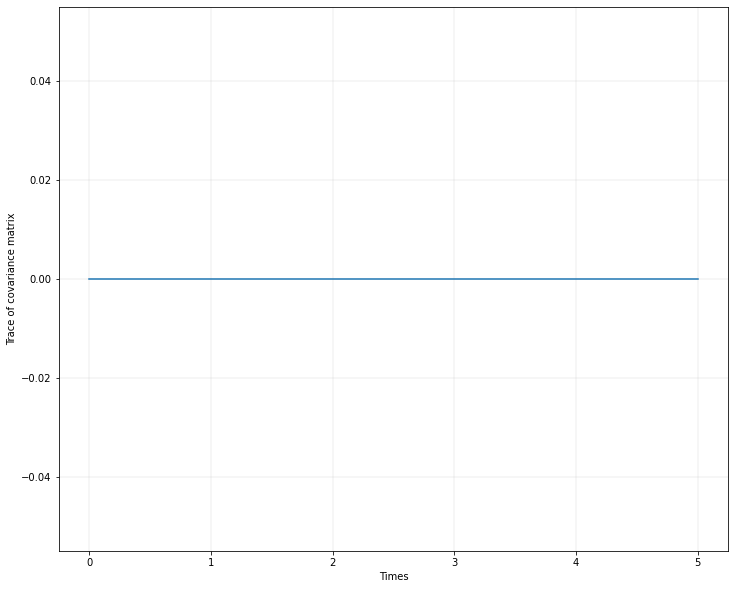

In [ ]:
#Declare a time array for testing 
dt=0.01
times=np.arange(0, 5+dt, dt)

#Declare the hamiltonian and the covariance matrix 
covMat=covariance_matrix(N, omega, lambdaa, blochVector, temperature)
hamiltonian=total_hamiltonian(N, omega, lambdaa)

#Evolve the covariance matrix
evolved_covMats=evolve_lambda(times, hamiltonian, covMat)

#Plotting the trace through time 
traces=np.zeros(len(times), dtype=float)
for ii in range(len(times)):
    traces[ii]=round(np.trace(evolved_covMats[ii]),3)

plt.figure(figsize=(12,10))
plt.plot(times, traces)
plt.grid(linewidth=0.2)
plt.xlabel('Times')
plt.ylabel('Trace of covariance matrix')

Looks good, the trace of the covariance matrix remains fixed at $0$ as it should. Progress on to some modelling and comparison to the brute force spin case.

# Comparison with Brute Force Spin Chain

In [ ]:
#Testing the function to find the sigma z expectation of covariance matrix first 
sigma_z=expt_sigmaZ1(covMat)

Generate $\left\langle \hat{\sigma}_1^z \right\rangle$ for the covariance matrix first and compare to brute force. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, '$\\left\\langle \\hat{\\sigma}_1^z \\right\\rangle$')

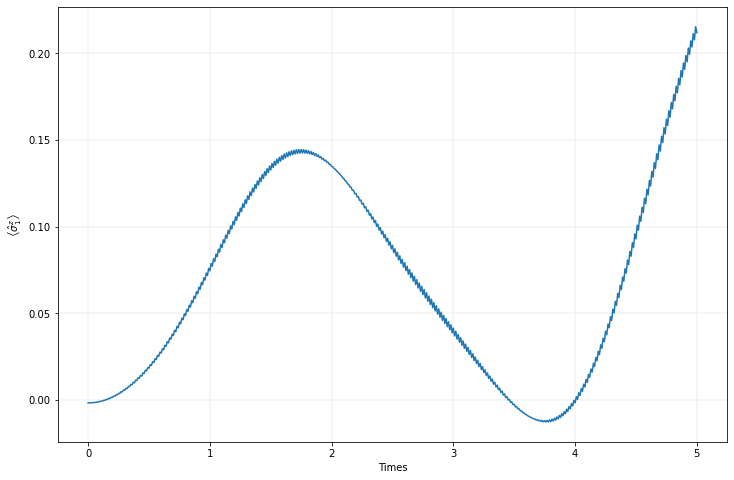

In [ ]:
sigmaZvalues=np.zeros(len(times), dtype=float)
for ii in range(len(times)):
    sigmaZvalues[ii]=expt_sigmaZ1(evolved_covMats[ii])

#Plotting how this chnages with time 
plt.figure(figsize=(12,8))
plt.plot(times, sigmaZvalues)
plt.grid(linewidth=0.2)
plt.xlabel('Times')
plt.ylabel(r'$\left\langle \hat{\sigma}_1^z \right\rangle$')

Now import the modules needed for the brute force case and compare it

In [ ]:
'''Functions'''
#Functions to generate the sigmas in the needed Hilbert space
def sigma_z_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_z=np.array([[1,0],[0,-1]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_z if current n=1
    elif current_term==1:
        final_sig_z=sigma_z
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
        return final_sig_z
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_z=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_z=np.kron(final_sig_z, sigma_z)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
        return final_sig_z

def sigma_plus_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_plus=np.array([[0,1],[0,0]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_ if current n=1
    elif current_term==1:
        final_sig_plus=sigma_plus
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2))
        return final_sig_plus
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_plus=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_plus=np.kron(final_sig_plus, sigma_plus)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2)) 
        return final_sig_plus    

def sigma_minus_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_minus=np.array([[0,0],[1,0]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_ if current n=1
    elif current_term==1:
        final_sig_minus=sigma_minus
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
        return final_sig_minus
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_minus=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_minus=np.kron(final_sig_minus, sigma_minus)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
        return final_sig_minus
    

    

#Hamiltonian is now split into 3 components 
#Code each component and include a final function to sum them all 
#Hamiltonian of the system of interest 
def H_s(wx, wy, wz, dimension):
    H_s=(wx*(sigma_plus_hilbert(1, dimension)+1j*sigma_minus_hilbert(1, dimension))+ #Generate the sigma_x array
         wy*(sigma_plus_hilbert(1,dimension)-1j*sigma_minus_hilbert(1, dimension))+
         wz*(sigma_z_hilbert(1,dimension)))
    return H_s

#Hamiltonian of the environmental terms
def H_e(w_z_array, lam_plus_array, lam_minus_array, dimension):
    term_1=np.zeros((2**dimension, 2**dimension), dtype=complex)
    term_2=np.zeros((2**dimension, 2**dimension), dtype=complex)
    H_e=np.zeros((2**dimension, 2**dimension), dtype=complex)
    if dimension<2:
        pass
    else:
        for ii in range(2, dimension+1):
            term_1+=w_z_array[ii-1]*sigma_z_hilbert(ii, dimension) #Minus 1 to account for python indexing starting at 0
        for ii in range(2, dimension):
            term_2+=(lam_minus_array[ii-1]*sigma_minus_hilbert(ii, dimension)@sigma_plus_hilbert(ii+1, dimension)+
                     lam_plus_array[ii]*sigma_plus_hilbert(ii, dimension)@sigma_plus_hilbert(ii+1, dimension))
        #Complete sum of hamiltonian
        H_e=term_1 + term_2 + term_2.conj().T
    return H_e

#Hamiltonian of the interaction between the environment and the system
def V_se(lam_plus_1, lam_minus_1, lam_z_1, dimension):
    term=0+0j
    V_se=0+0j
    term+=(lam_minus_1*sigma_minus_hilbert(1, dimension)+
           lam_plus_1*sigma_plus_hilbert(1,dimension)+
           lam_z_1*sigma_z_hilbert(1,dimension))@sigma_plus_hilbert(2,dimension)
    #Sum for hamiltonian term
    V_se+=term+term.conj().T
    return V_se
    
#Complete Hamiltonian Function
def H_total(dimension, w_matrix, lam_matrix):
    return (H_s(w_matrix[0,0], w_matrix[0,1], w_matrix[0,2], dimension) +
            H_e(w_matrix[:,0], lam_matrix[:,0], lam_matrix[:,1], dimension) +
            V_se(lam_matrix[0,0], lam_matrix[0,1], lam_matrix[0,2], dimension))
        



    
#Initial state that needs to be evolved through time
#Given a Bloch vector nx ny nz and environment temperature 
def initial_state(nx, ny, nz, temperature, w_matrix, lam_matrix, dimension):
    len_state=np.sqrt(nx**2 + ny**2 + nz**2)
    if len_state>1:
        error_string='Error! The Bloch vector can at most be length 1, you entered a vector of length %f' % len_state
        return error_string
    else:
        #Need to generate the system state and the environment state 
        system_state=np.zeros((2,2), dtype=complex)
        environment_state=np.zeros((2**(dimension-1), 2**(dimension-1)), dtype=complex)
        #Placeholder for the total state 
        total_state=np.zeros((2**dimension, 2**dimension), dtype=complex)
        
        #Generate the system state
        system_state+=0.5*(np.identity(2, dtype=complex)+
                          nx*(sigma_plus_hilbert(1, 1)+1j*sigma_minus_hilbert(1, 1))+
                          ny*(sigma_plus_hilbert(1, 1)-1j*sigma_minus_hilbert(1,1))+
                          nz*sigma_z_hilbert(1, 1))
        
        #Placeholder for the environment state since the partition is just the trace of this 
        beta=1/temperature
        placeholder=LA.expm(-beta * H_e(w_matrix[:,0], lam_matrix[:,0], lam_matrix[:,1], dimension-1))
        partition=np.trace(placeholder)
        environment_state+=placeholder/partition
        
        #Now declare the final state
        total_state+=np.kron(system_state, environment_state)
        return total_state




#The time evolution unitary operator
def U(N, t):
    #Take hbar=1
    arg=1j*hamiltonian(N)*t
    #Exponentiate the matrix argument
    return LA.expm(arg)




#Function for evolving a state forward in time
def evolve_exponentiation(time_array, initial_matrix, dimension, w_matrix, lam_matrix):
    #Time spacing
    dt=time_array[1]-time_array[0]
    
    #Create a tensor to hold the density matrix values through time
    dens_tensor=np.zeros((len(time_array), len(initial_matrix), 2**dimension), dtype=complex)

    #Set the initial value 
    dens_tensor[0]=initial_matrix 

    #Only need to calculate the U matrix once since the Hamiltonian is time-independent 
    #Save computational power 
    U_mat_dt=np.zeros((len(initial_matrix), 2**dimension), dtype=complex)
    U_mat_dt+=LA.expm(1j * H_total(dimension, w_matrix, lam_matrix) * dt)

    #Loop through the other values
    for ii in range(1, len(time_array)):
        #Test that the matrix is unitary 
        print(U_mat_dt@U_mat_dt.conj().T)
        dens_tensor[ii]=(U_mat_dt@dens_tensor[ii-1])
        dens_tensor[ii]=dens_tensor[ii]@U_mat_dt.conj().T
    return dens_tensor




#Function that uses numerical integration instead of matrix exponentiation to potentially 
#reduce computational complexity
def evolve_integrator(time_array, initial_matrix, dimension, w_matrix, lam_matrix):
    #Need to define a tensor to hold each density matrix at time intervals 
    dt=time_array[1]-time_array[0]

    #Need a tensor to hold the density matrices at each time interval
    #Dimension 0 is how many matrices we have; the length of the time array
    #Dimension 1 and 2 are the dimensions of the matrices themselves 
    #Important to declare the dtype as complex such that we don't cast complex values to real ones
    dens_tensor=np.zeros((len(time_array), len(initial_matrix), len(initial_matrix)), dtype=complex)

    #Set both the 0th and 1st elements to the intial density matrix
    dens_tensor[0]=initial_matrix
    dens_tensor[1]=initial_matrix

    #Now iterate over the other elements of the density tensor
    for ii in range(1, len(time_array)-1):
        #Define the commutator for this iteration
        current_H=H_total(dimension, w_matrix, lam_matrix)
        commutator=current_H@dens_tensor[ii] - dens_tensor[ii]@current_H

        #Now apply the finite difference algorithm
        dens_tensor[ii+1]=dens_tensor[ii-1] - 2j*commutator*dt

    #Now return the density tensor
    return dens_tensor




#Function to track the trace of the density matrix throughout the calculations
def track_trace(density_tensor):
    traces=np.zeros(len(density_tensor), dtype=complex)
    for ii in range(len(density_tensor)):
        traces[ii]=np.trace(density_tensor[ii])
    return traces

#Find the expectation of sigma_^z_1 given the density matrix 
def sigma_z1_BF(density_matrix):
    #Infer the dimension from the density matrix 
    dim=int(np.log2(len(density_matrix)))

    #Sigma needed 
    sigZ1=sigma_z_hilbert(1, dim)

    #Expectation value 
    expectation=np.trace(density_matrix@sigZ1)

    #Return the expectation value 
    return expectation

In [ ]:
#Find the brute force states 
BF_initial=initial_state(blochVector[0], blochVector[1], blochVector[2], temperature, omega, lambdaa, N)
BF_densityTensor=evolve_integrator(times, BF_initial, N, omega, lambdaa)
BF_expectation=np.zeros(len(times), dtype=float)
for ii in range(len(times)):
    BF_expectation[ii]=sigma_z1_BF(BF_densityTensor[ii])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


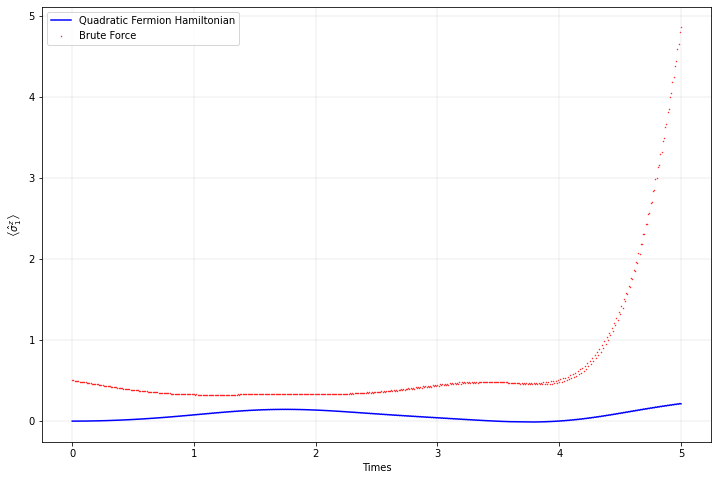

In [ ]:
#Plotting the comparison of the two 
plt.figure(figsize=(12,8))
plt.plot(times, sigmaZvalues, linestyle='-', color='blue', label='Quadratic Fermion Hamiltonian')
plt.scatter(times, BF_expectation, color='red', label='Brute Force', s=0.2)
plt.grid(linewidth=0.2)
plt.xlabel('Times')
plt.ylabel(r'$\left\langle \hat{\sigma}_1^z \right\rangle$')
plt.legend()